In [1]:
!pip install pyspark==3.5.1 findspark


In [2]:
import findspark
findspark.init()


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("FlightDelay_Prediction_Model")
    .master("local[*]")
    .config("spark.sql.shuffle.partitions", "4")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .getOrCreate()
)

print("Spark Ready!", spark.version)


Spark Ready! 3.5.1


In [5]:
!apt-get install -qq openjdk-11-jdk-headless > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark


E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jre-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 185.125.190.83 80]
E: Failed to fetch http://security.ubuntu.com/ubuntu/pool/main/o/openjdk-lts/openjdk-11-jdk-headless_11.0.28%2b6-1ubuntu1%7e22.04.1_amd64.deb  404  Not Found [IP: 185.125.190.83 80]
E: Unable to fetch some archives, maybe run apt-get update or try with --fix-missing?


In [4]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

findspark.init()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("FlightDelay_Prediction_Model")
    .master("local[*]")
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .config("spark.sql.shuffle.partitions", "4")
    .getOrCreate()
)

print("🔥 Spark Ready!", spark.version)


🔥 Spark Ready! 3.5.1


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
df = spark.read.parquet(
    "/content/drive/MyDrive/flight_delay_analysis_project/Outputs/preview_sample.parquet"
)

print("Data loaded successfully!")
df.printSchema()
df.show(5)

Data loaded successfully!
root
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- DAY: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- FLIGHT_NUMBER: integer (nullable = true)
 |-- TAIL_NUMBER: string (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DESTINATION_AIRPORT: string (nullable = true)
 |-- SCHEDULED_DEPARTURE: integer (nullable = true)
 |-- DEPARTURE_TIME: integer (nullable = true)
 |-- DEPARTURE_DELAY: double (nullable = true)
 |-- TAXI_OUT: integer (nullable = true)
 |-- WHEELS_OFF: integer (nullable = true)
 |-- SCHEDULED_TIME: integer (nullable = true)
 |-- ELAPSED_TIME: integer (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- WHEELS_ON: integer (nullable = true)
 |-- TAXI_IN: integer (nullable = true)
 |-- SCHEDULED_ARRIVAL: integer (nullable = true)
 |-- ARRIVAL_TIME: integer (nullable = true)
 |-- ARRIV

In [12]:
from pyspark.sql.functions import when, col

# 1. Create label column (1 = delayed, 0 = on time)
df = df.withColumn(
    "LABEL_DELAYED",
    when(col("ARRIVAL_DELAY") > 15, 1).otherwise(0)
)

# 2. Select features
# Create SMALL DF first
small_source = df.limit(2_000_000)   # only first 2 million rows

model_df = small_source.select(
    "MONTH",
    "DAY_OF_WEEK",
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "DEPARTURE_DELAY",
    "DISTANCE",
    "ARRIVAL_DELAY",
    "LABEL_DELAYED"   # <-- FIXED
)
print("Model dataset created!")
model_df.show(5)



Model dataset created!
+-----+-----------+-------+--------------+-------------------+---------------+--------+-------------+-------------+
|MONTH|DAY_OF_WEEK|AIRLINE|ORIGIN_AIRPORT|DESTINATION_AIRPORT|DEPARTURE_DELAY|DISTANCE|ARRIVAL_DELAY|LABEL_DELAYED|
+-----+-----------+-------+--------------+-------------------+---------------+--------+-------------+-------------+
|    1|          4|     B6|           SJU|                JFK|           -2.0|  1598.0|         11.0|            0|
|    1|          4|     B6|           SJU|                JFK|           -2.0|  1598.0|         11.0|            0|
|    1|          4|     B6|           SJU|                JFK|           -2.0|  1598.0|         11.0|            0|
|    1|          4|     B6|           SJU|                JFK|           -2.0|  1598.0|         11.0|            0|
|    1|          4|     B6|           SJU|                JFK|           -2.0|  1598.0|         11.0|            0|
+-----+-----------+-------+--------------+-------

In [13]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

cat_cols = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_IDX") for c in cat_cols]
encoders = [OneHotEncoder(inputCol=c+"_IDX", outputCol=c+"_VEC") for c in cat_cols]


In [14]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    "MONTH",
    "DAY_OF_WEEK",
    "DEPARTURE_DELAY",
    "DISTANCE",
    "AIRLINE_VEC",
    "ORIGIN_AIRPORT_VEC",
    "DESTINATION_AIRPORT_VEC"
]

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)


In [15]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

lr = LogisticRegression(featuresCol="features", labelCol="LABEL_DELAYED")

pipeline = Pipeline(stages=indexers + encoders + [assembler, lr])


In [16]:
sample_df = model_df.sample(withReplacement=False, fraction=0.05, seed=42)

train_df, test_df = sample_df.randomSplit([0.8, 0.2], seed=42)

print("Train:", train_df.count(), "Test:", test_df.count())


Train: 79875 Test: 20092


In [17]:
model = pipeline.fit(train_df)
print("Model trained successfully!")


Model trained successfully!


In [18]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predictions on test data
pred_df = model.transform(test_df)

# Binary evaluator for AUC
auc_eval = BinaryClassificationEvaluator(
    labelCol="LABEL_DELAYED",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)
auc = auc_eval.evaluate(pred_df)

# Multiclass evaluators for precision, recall, F1
accuracy_eval = MulticlassClassificationEvaluator(
    labelCol="LABEL_DELAYED",
    predictionCol="prediction",
    metricName="accuracy"
)

precision_eval = MulticlassClassificationEvaluator(
    labelCol="LABEL_DELAYED",
    predictionCol="prediction",
    metricName="precisionByLabel"
)

recall_eval = MulticlassClassificationEvaluator(
    labelCol="LABEL_DELAYED",
    predictionCol="prediction",
    metricName="recallByLabel"
)

f1_eval = MulticlassClassificationEvaluator(
    labelCol="LABEL_DELAYED",
    predictionCol="prediction",
    metricName="f1"
)

accuracy = accuracy_eval.evaluate(pred_df)
precision = precision_eval.evaluate(pred_df)
recall = recall_eval.evaluate(pred_df)
f1 = f1_eval.evaluate(pred_df)

print("=== MODEL PERFORMANCE ===")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)


=== MODEL PERFORMANCE ===
Accuracy: 0.9034441568783595
Precision: 0.9091080876795162
Recall: 0.9667113194909578
F1 Score: 0.9000566842132651
AUC: 0.929973357523019


In [19]:
pred_df.groupBy("LABEL_DELAYED", "prediction").count().show()


+-------------+----------+-----+
|LABEL_DELAYED|prediction|count|
+-------------+----------+-----+
|            0|       0.0|14433|
|            1|       0.0| 1443|
|            1|       1.0| 3719|
|            0|       1.0|  497|
+-------------+----------+-----+



In [20]:
# Generate predictions on test dataset
pred_df = model.transform(test_df)

pred_df.select("LABEL_DELAYED", "prediction", "probability").show(5)


+-------------+----------+--------------------+
|LABEL_DELAYED|prediction|         probability|
+-------------+----------+--------------------+
|            0|       0.0|[0.87028991818297...|
|            0|       0.0|[0.85561215526132...|
|            0|       0.0|[0.85561215526132...|
|            0|       0.0|[0.98865530869413...|
|            0|       0.0|[0.98361655113396...|
+-------------+----------+--------------------+
only showing top 5 rows



In [21]:
# Convert to Pandas for sklearn metrics
pdf = pred_df.select("LABEL_DELAYED", "prediction").toPandas()

y_true = pdf["LABEL_DELAYED"]
y_pred = pdf["prediction"]


In [22]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))


Accuracy: 0.9034441568783595
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     14930
           1       0.88      0.72      0.79      5162

    accuracy                           0.90     20092
   macro avg       0.90      0.84      0.87     20092
weighted avg       0.90      0.90      0.90     20092



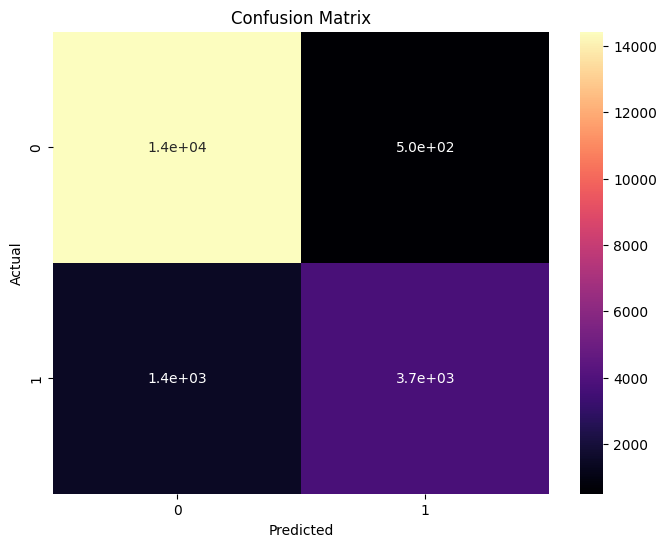

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='.1e', cmap="magma")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
# Create pipeline stages for reuse across all models
pipeline_stages = indexers + encoders + [assembler]

print("Pipeline stages created!")


Pipeline stages created!



TRAINING MODEL: Logistic Regression

Accuracy for Logistic Regression: 0.9034441568783595

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     14930
           1       0.88      0.72      0.79      5162

    accuracy                           0.90     20092
   macro avg       0.90      0.84      0.87     20092
weighted avg       0.90      0.90      0.90     20092



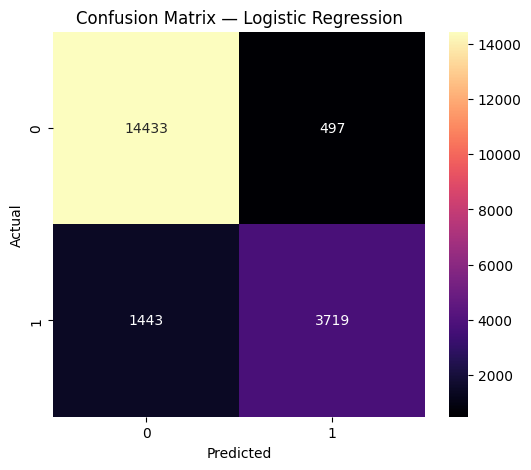


TRAINING MODEL: Decision Tree

Accuracy for Decision Tree: 0.9028966752936493

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     14930
           1       0.89      0.71      0.79      5162

    accuracy                           0.90     20092
   macro avg       0.90      0.84      0.86     20092
weighted avg       0.90      0.90      0.90     20092



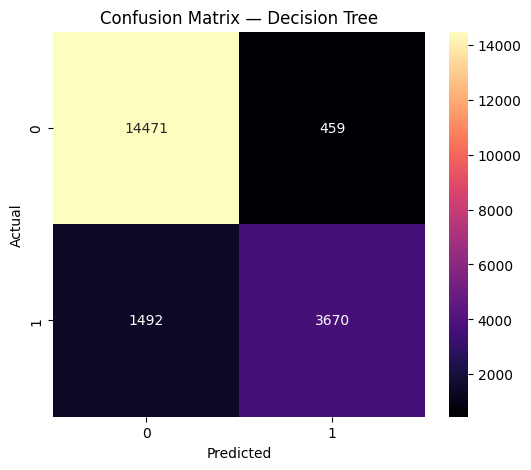


TRAINING MODEL: Random Forest

Accuracy for Random Forest: 0.8983675094565001

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93     14930
           1       0.91      0.67      0.77      5162

    accuracy                           0.90     20092
   macro avg       0.90      0.82      0.85     20092
weighted avg       0.90      0.90      0.89     20092



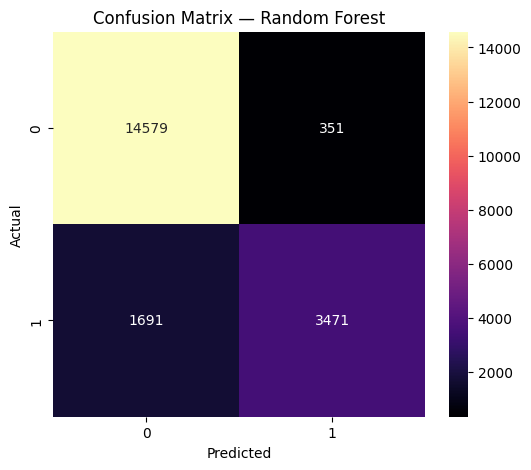


TRAINING MODEL: Gradient Boosted Trees

Accuracy for Gradient Boosted Trees: 0.9056838542703564

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     14930
           1       0.91      0.71      0.79      5162

    accuracy                           0.91     20092
   macro avg       0.91      0.84      0.87     20092
weighted avg       0.91      0.91      0.90     20092



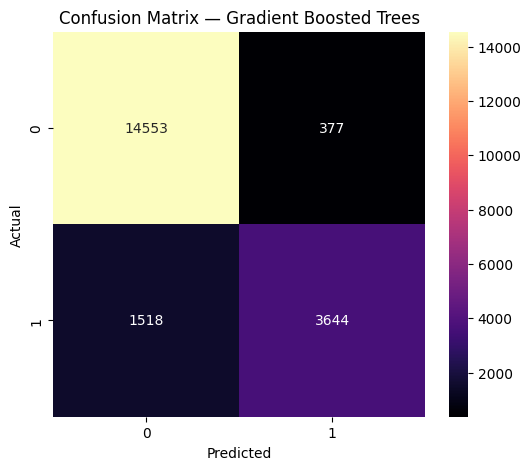



==================== FINAL MODEL ACCURACY COMPARISON ====================


,Model,Accuracy
3,Gradient Boosted Trees,0.905684
0,Logistic Regression,0.903444
1,Decision Tree,0.902897
2,Random Forest,0.898368



BEST MODEL = Gradient Boosted Trees
Use this model for final predictions.



In [26]:
# ============================================
# 1) MODEL LIST
# ============================================

from pyspark.ml.classification import (
    LogisticRegression,
    DecisionTreeClassifier,
    RandomForestClassifier,
    GBTClassifier
)
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    "Logistic Regression": LogisticRegression(featuresCol="features", labelCol="LABEL_DELAYED"),
    "Decision Tree": DecisionTreeClassifier(featuresCol="features", labelCol="LABEL_DELAYED"),
    "Random Forest": RandomForestClassifier(featuresCol="features", labelCol="LABEL_DELAYED", numTrees=50, maxDepth=10),
    "Gradient Boosted Trees": GBTClassifier(featuresCol="features", labelCol="LABEL_DELAYED", maxIter=20)
}

results = {}

# ============================================
# 2) TRAIN, PREDICT & EVALUATE EACH MODEL
# ============================================

def evaluate_model(model_name, model_obj):
    print("\n" + "="*80)
    print(f"TRAINING MODEL: {model_name}")
    print("="*80)

    # Build pipeline
    pipeline = Pipeline(stages=pipeline_stages + [model_obj])

    # Train
    model = pipeline.fit(train_df)

    # Predict
    pred_df = model.transform(test_df)
    pdf = pred_df.select("LABEL_DELAYED", "prediction").toPandas()

    y_true = pdf["LABEL_DELAYED"]
    y_pred = pdf["prediction"]

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\nAccuracy for {model_name}: {acc}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='g', cmap="magma")
    plt.title(f"Confusion Matrix — {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Save results
    results[model_name] = acc

    return model, acc


trained_models = {}

for model_name, model_obj in models.items():
    trained_model, acc = evaluate_model(model_name, model_obj)
    trained_models[model_name] = trained_model


# ============================================
# 3) FINAL COMPARISON TABLE
# ============================================

print("\n\n==================== FINAL MODEL ACCURACY COMPARISON ====================")
comparison_df = pd.DataFrame(results.items(), columns=["Model", "Accuracy"]).sort_values("Accuracy", ascending=False)
display(comparison_df)

best_model_name = comparison_df.iloc[0]["Model"]
print(f"\nBEST MODEL = {best_model_name}")
print("Use this model for final predictions.\n")


In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="LABEL_DELAYED")

for model_name, model in trained_models.items():
    preds = model.transform(test_df)
    auc = evaluator.evaluate(preds)
    print(f"{model_name} AUC = {auc:.4f}")


Logistic Regression AUC = 0.9300
Decision Tree AUC = 0.5815
Random Forest AUC = 0.8971
Gradient Boosted Trees AUC = 0.9307


In [31]:
save_path = "/content/drive/MyDrive/flight_delay_analysis_project/Models/best_spark_model"

model.write().overwrite().save(save_path)
print("Saved at:", save_path)


Saved at: /content/drive/MyDrive/flight_delay_analysis_project/Models/best_spark_model
